In [1]:
import numpy as np
import xarray as xr
import geopandas as gpd
import glob
import warnings
from scipy.stats import norm

import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
## custom
from dirs import wrfdir, basedir, coorddir, snoteldir, outputsdir

plt.style.use('style.mplstyle')
plt.rcParams['font.family'] = 'sans-serif'

warnings.filterwarnings("ignore")


/global/homes/c/cowherd/.conda/envs/fos/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
plasma_colors = ["#ffd700",
"#ffb14e",
"#fa8775",
"#ea5f94",
"#cd34b5",
"#9d02d7",
"#0000ff"]

colors_data = {'Data_1':'#ffd700', 'Data_2':'#fa8775', 'Data_3':'#ea5f94', 'Data_4':'#cd34b5','Data_5':'#0000ff'}
styles_model = {'linreg': '-', 'RF': '--', 'Unet': ':'}
labels_model = {'linreg': 'Linear Regression', 'RF': 'Random Forest', 'Unet': 'U-Net'}
colors_model = {'linreg':'black', 'RF':'gray', 'Unet': 'lightgray'}
colors_list = [plasma_colors[2], plasma_colors[4], plasma_colors[6]]
datagrps = [[0,1],[2,3],[4]]
datagroups = [['Data_1','Data_2'], ['Data_3', 'Data_4'], ['Data_5']]
labels = ['snow pillow', '+gridded', '+intensive']


In [3]:
# Function to plot fitted normal distribution
def plot_fitted_normal(data, ax, color, orientation = 'horizontal'):
    data = data[data>-2]
    mu, std = norm.fit(data)
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    if orientation == 'horizontal':
        ax.plot(x, p, color=color)
    if orientation == 'vertical':
        ax.plot(p,x, color = color)
        
# Function to create scatter plot with marginal histograms
def scatter_hist(x, y, ax, ax_histx, ax_histy, color, label, DIST = True):
    # Remove labels
    # ax_histx.tick_params(axis="x", labelbottom=False)
    # ax_histy.tick_params(axis="y", labelleft=False)

    ax.scatter(x, y, color = color, label = label, alpha = 0.4, marker = '+')
    ax.set_yticks([-1,0,1])

    # Fit and plot normal distribution on the scatter plot
    if DIST:
        plot_fitted_normal(x, ax_histx, color=color, orientation = 'horizontal')
        plot_fitted_normal(y,ax_histy, color=color, orientation = 'vertical')

        

In [4]:
## 1 show change in error by different model-year combinations, and then show the change in time
## 2 show what happens when you collapse the Data 3 and 4 rror proportions a la SAIL

In [5]:
## prep error data
outputsdir = '/global/cfs/cdirs/m4099/fate-of-snotel/wrfdata/umital/Fig4_results/'
err = xr.open_dataset(f'{outputsdir}/err_allmodels_syntherr.nc').rename({'__xarray_dataarray_variable__':'value'})
exclude_value = "Northern Oregon Coastal" ## low snow, does not make sense to include due to near-0 denominator
mask = err["basin"] != exclude_value
err = err.where(mask, drop=True)

exclude_values = ["Northern Oregon Coastal", "Rio Grande-Elephant Butte", "San Joaquin"]
for val in exclude_values:
    mask = err["basin"] != val
    err = err.where(mask, drop=True)
models = err.model.values
gcms = err.gcm.values
basins = err.basin.values
years = err.test_year.values
datas = err.pred_combo.values
metrics = err.metric.values

r2vals = err.sel(metric = 'r2')
rmsevals = err.sel(metric='rmse')

In [6]:
##just generate the numbers and save it and then plot them in the second oe
outdatas = {}
for i,data in enumerate(datas):
    outdatas[data] = {}
    for j,model in enumerate(models):
        outdatas[data][model] = []
        for n in range(len(basins)):
            name = basins[n]
            mydata = r2vals.sel(basin = name).sel(pred_combo = data).sel(model = model).mean(dim = 'gcm')['value']
            outdatas[data][model].append(mydata)

In [7]:
## print some statistics
def compare_lr_rf_unet(lr,rf,unet, y1, y2):
    lr_val = lr[:,y1:y2].flatten()
    rf_val = rf[:,y1:y2].flatten()
    unet_val = unet[:,y1:y2].flatten()

    rf_better = np.nanmean((rf_val - lr_val) / lr_val) * 100
    unet_better = np.nanmean((unet_val - lr_val) / lr_val) * 100
    print(f'rf is {rf_better} percent better than lr for {y1}-{y2}')
    print(f'unet is {unet_better} percent better than lr for {y1}-{y2}')
    return lr_val, rf_val, unet_val

def compare_data_type(p1,p2,p3, y1, y2):
    p1_val = p1[:,y1:y2].flatten()
    p2_val = p2[:,y1:y2].flatten()
    p3_val = p3[:,y1:y2].flatten()

    p2_better = np.nanmean((p2_val - p1_val) / p1_val) * 100
    p3_better = np.nanmean((p3_val - p1_val) / p1_val) * 100
    print(f'gridded is {p2_better} percent better than pillow for {y1}-{y2}')
    print(f'intensive is {p3_better} percent better than pillow for {y1}-{y2}')
    return

In [8]:
for pred_combos in datagroups:
    lr = r2vals.sel(pred_combo = pred_combos).mean(dim = 'pred_combo').sel(model = 'linreg').mean(dim = 'basin').value.values
    rf = r2vals.sel(pred_combo = pred_combos).mean(dim = 'pred_combo').sel(model = 'RF').mean(dim = 'basin').value.values
    unet = r2vals.sel(pred_combo = pred_combos).mean(dim = 'pred_combo').sel(model = 'Unet').mean(dim = 'basin').value.values
    y1 = 0
    y2 = 20
    print(pred_combos)
    compare_lr_rf_unet(lr,rf,unet, y1, y2)

['Data_1', 'Data_2']
rf is -108.43752748839226 percent better than lr for 0-20
unet is 395.94342536847915 percent better than lr for 0-20
['Data_3', 'Data_4']
rf is 8.248529831208307 percent better than lr for 0-20
unet is 12.460296747003616 percent better than lr for 0-20
['Data_5']
rf is 2.003938128403379 percent better than lr for 0-20
unet is -5.146532944728892 percent better than lr for 0-20


In [9]:
for model in models:
    p1 = r2vals.sel(pred_combo = ['Data_1', 'Data_2']).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'basin').value.values
    p2 = r2vals.sel(pred_combo = ['Data_3', 'Data_4']).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'basin').value.values
    p3 = r2vals.sel(pred_combo = ['Data_5']).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'basin').value.values
    y1 = 15
    y2 = 20
    print(model)
    compare_data_type(p1,p2,p3, y1, y2)

linreg
gridded is 184.18947633832065 percent better than pillow for 15-20
intensive is 226.63236275833154 percent better than pillow for 15-20
RF
gridded is 620.1676943818343 percent better than pillow for 15-20
intensive is 710.6066909668687 percent better than pillow for 15-20
Unet
gridded is -4.194444837823856 percent better than pillow for 15-20
intensive is 3.011453075070305 percent better than pillow for 15-20


In [10]:
for pred_combos in datagroups:
    lr = r2vals.sel(pred_combo = pred_combos).mean(dim = 'pred_combo').sel(model = 'linreg').mean(dim = 'basin').value.values
    rf = r2vals.sel(pred_combo = pred_combos).mean(dim = 'pred_combo').sel(model = 'RF').mean(dim = 'basin').value.values
    unet = r2vals.sel(pred_combo = pred_combos).mean(dim = 'pred_combo').sel(model = 'Unet').mean(dim = 'basin').value.values
    y1 = 15
    y2 = 20
    print(pred_combos)
    compare_lr_rf_unet(lr,rf,unet, y1, y2)

['Data_1', 'Data_2']
rf is -8.306078493527101 percent better than lr for 15-20
unet is 193.9985954559106 percent better than lr for 15-20
['Data_3', 'Data_4']
rf is 3.597161847711295 percent better than lr for 15-20
unet is 4.357267794831218 percent better than lr for 15-20
['Data_5']
rf is 3.6257695374633205 percent better than lr for 15-20
unet is 1.5887006100985406 percent better than lr for 15-20


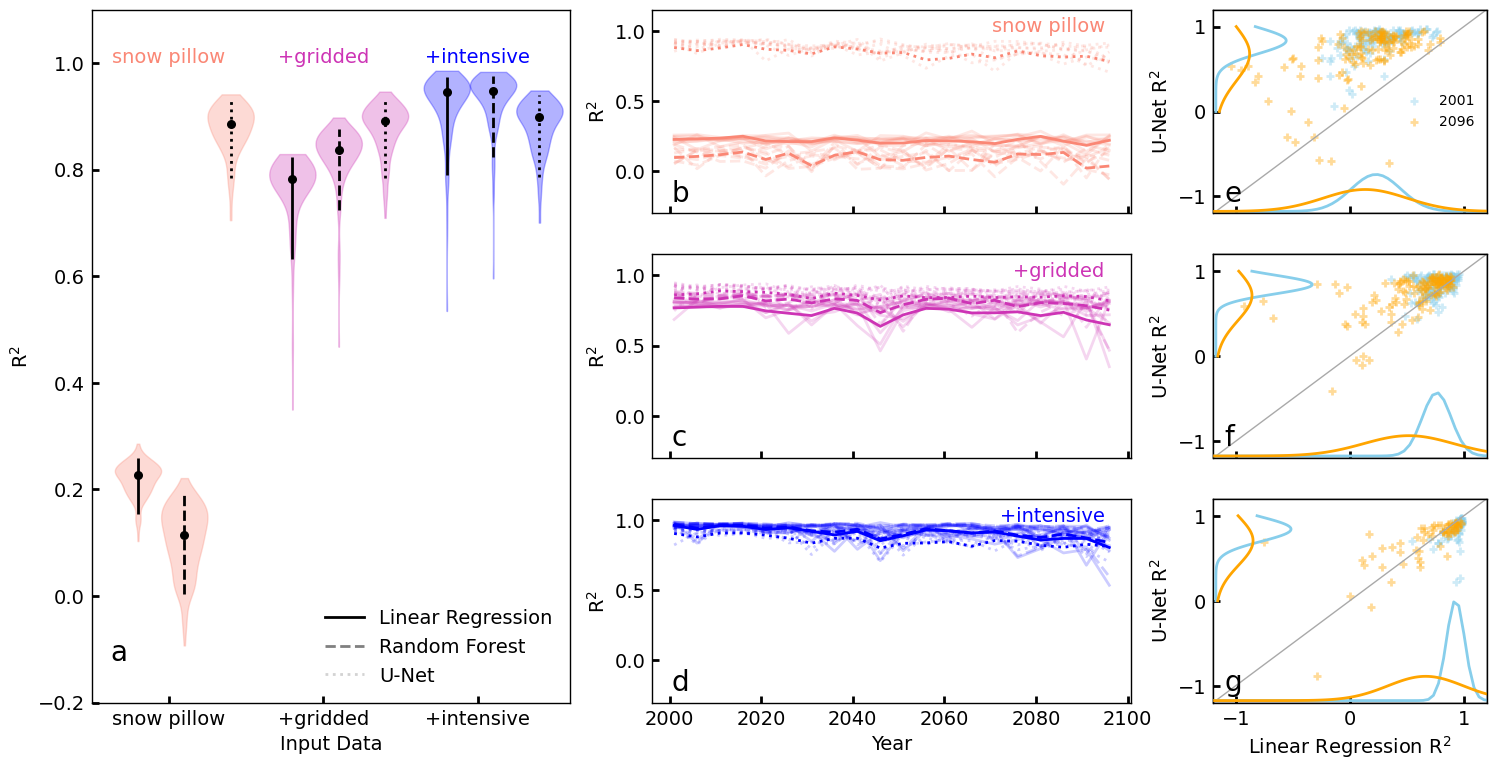

In [11]:
LETTERS = True
plt.rcParams['xtick.major.size'] = 5 
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.top'] = False  
plt.rcParams['ytick.right'] = False 
# datagrps = [[0],[1],[2],[3],[4]]
datagrps = [[0,1],[2,3],[4]]
datagroups = [['Data_1','Data_2'], ['Data_3', 'Data_4'], ['Data_5']]
labels = ['SNOTEL', 'Gridded', 'Intensive']

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

mosaic = """
    ABE
    ACF
    ADG
    """
letters = ['B','C','D']

fig = plt.figure(figsize=(18, 9)) # , layout="tight", constrained_layout=True) #, gridspec_kw={"width_ratios": [1, 1, 1]})
#gs = fig.add_gridspec(3, 3, width_ratios=[5, 5, 3])


ax_dict = fig.subplot_mosaic(mosaic,
    height_ratios=[1, 1, 1],
    width_ratios=[7,7,4],)
ax = ax_dict['A']
allpcs = []
for c,model in enumerate(models):
    mypositions = [num + (c+1) *0.3 for num in range(3)]
    tmp_model = []
    for pred_combos in datagroups:
        data2plot = r2vals.sel(pred_combo = pred_combos).mean(dim = 'pred_combo').sel(model = model).median(dim = 'basin').value.values
        tmp_model.append(data2plot.flatten())
    prep_boxplots = tmp_model
    prep_boxplots = [arr for arr in prep_boxplots]
    vplot = ax.violinplot(prep_boxplots, positions = mypositions, 
                          showmeans = False, showextrema = False,
                         widths = 0.3)# , color = colors_models[model]) #, label = model)# linestyle = styles_model[model], color = colors_model[model])

    allpcs.append(vplot['bodies'])

    quartile1, medians, quartile3 = np.percentile(prep_boxplots, [5,50, 95], axis=1)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(prep_boxplots, quartile1, quartile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, -1]

    ax.scatter(mypositions, medians, marker='o', color='k', s=30, zorder=3)
    ax.vlines(mypositions, quartile1, quartile3, color='k', linestyle = styles_model[model], lw=2)
    #ax.vlines(mypositions, whiskers_min, whiskers_max, color=colors_model[model])# , linestyle = styles_model[model], lw=1)
ticks, labels = [0.5,1.5,2.5], ['snow pillow', '+gridded', '+intensive']
ax.set_xticks(ticks, labels)
for i, tick in enumerate(ticks):
    ax.text(tick, 1, labels[i], horizontalalignment ='center', color = colors_list[i])


for i, color in enumerate(colors_list):
    for pc in allpcs:
        pc[i].set_facecolor(color)
        pc[i].set_edgecolor(color)
        
# ax.set_yscale('log')
for model in models:
    ax.plot([-10,-10],[-10,-10], color = colors_model[model], label = labels_model[model], linestyle = styles_model[model])
ax.set_ylim((-0.2,1.1))
ax.set_xlim((-0.0,3.1))

ax.set_xlabel('Input Data')
ax.set_ylabel(r'R$^{2}$')
ax.legend( loc = 'lower right')
for i, idxs in enumerate(datagrps):
    value = [datas[idx] for idx in idxs] 
    ax = ax_dict[letters[i]]
    idxs = datagrps[i]
    for model in models:
        for gcm in gcms:
            ax.plot(years, r2vals.sel(pred_combo = value).mean(dim = 'pred_combo').sel(model = model).sel(gcm = gcm).median(dim = 'basin').value, alpha = 0.2, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])
        ax.plot(years, r2vals.sel(pred_combo = value).mean(dim = 'pred_combo').sel(model = model).mean(dim = 'gcm').median(dim = 'basin').value, alpha = 1, color = colors_data[value[-1]], label = labels_model[model], linestyle = styles_model[model])

    ax.set_ylim((-0.3,1.15))
    ax.set_ylabel(r'R$^{2}$')
    ax.text(2095,0.99,labels[i], color = colors_data[value[-1]],ha = 'right')
    if i < 2:
        ax.set_xticklabels([])
ax.set_xlabel('Year')

## horror show year vs "good year"
year_1 = 2001
year_2 = 2096

# Function to plot fitted normal distribution
def plot_fitted_normal(data, ax, color, orientation = 'horizontal'):
    data = data[data>-2]
    mu, std = norm.fit(data)
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    if orientation == 'horizontal':
        ax.plot(x, p, color=color)
    if orientation == 'vertical':
        ax.plot(p,x, color = color)
def set_border(ax, width = 1):
     
    #not sure how they ended up wide?
    ax.spines['top'].set_linewidth(width)
    ax.spines['right'].set_linewidth(width)
    ax.spines['bottom'].set_linewidth(width)
    ax.spines['left'].set_linewidth(width)
    
    return

letters = ['E','F','G']
for i, data in enumerate(datagroups):
    unet1 = r2vals.sel(test_year = year_1).mean(dim = 'gcm').sel(pred_combo = data).sel(model = 'Unet').value.data.flatten()
    linreg1 = r2vals.sel(test_year = year_1).mean(dim = 'gcm').sel(pred_combo = data).sel(model = 'linreg').value.data.flatten()
    rf1 = r2vals.sel(test_year = year_1).mean(dim = 'gcm').sel(pred_combo = data).sel(model = 'RF').value.data.flatten()
    unet2 = r2vals.sel(test_year = year_2).mean(dim = 'gcm').sel(pred_combo = data).sel(model = 'Unet').value.data.flatten()
    linreg2 = r2vals.sel(test_year = year_2).mean(dim = 'gcm').sel(pred_combo = data).sel(model = 'linreg').value.data.flatten()
    rf2 = r2vals.sel(test_year = year_2).mean(dim = 'gcm').sel(pred_combo = data).sel(model = 'RF').value.data.flatten()
    ax = ax_dict[letters[i]]
    ax.plot([-2,2],[-2,2], linewidth = 1, color = 'darkgray')
    DIST = False
    ax_histx = fig.add_subplot(ax, sharex=ax)
    ax_histy = fig.add_subplot(ax, sharey=ax)
    scatter_hist(linreg1, unet1, ax, ax_histx, ax_histy, color = 'skyblue', label = '2001', DIST = DIST)
    scatter_hist(linreg2, unet2, ax, ax_histx, ax_histy, color = 'orange', label = '2096',DIST = DIST)
    if i ==0: ax.legend(loc = 'center right', fontsize = 10)
    for j,x in enumerate([[linreg1, linreg2], [unet1, unet2]]):
        if j ==0:
            color = 'skyblue'
            for xm in x:
                axm = ax.twinx()
                plot_fitted_normal(xm, axm, color=color, orientation = 'horizontal')
                axm.set_xlim((-1.2,1.2))
                axm.set_ylim((-0.1,10))
                axm.set_yticks([])
                color = 'orange'
                set_border(axm, 0.1)

        else:
            color = 'skyblue'
            for xm in x:
                axm = ax.twiny()
                plot_fitted_normal(xm, axm, color = color, orientation = 'vertical')
                axm.set_ylim((-1.2,1.2))
                axm.set_xlim((-0.1,10))
                axm.set_xticks([])
                color = 'orange'
                set_border(axm,.1)
    

    ax.set_xlim((-1.2,1.2))
    ax.set_ylim((-1.2,1.2))
    ax.set_ylabel(r'U-Net R$^{2}$')
    
  
ax.set_xlabel(r'Linear Regression R$^{2}$')

for letter in ['E','F']:
    ax = ax_dict[letter]
    ax.set_xticklabels([])
    # ax.set_xticklabels(['0','0.5','1'])  
    # ax.set_yticklabels(['0','0.5','1'])  

if LETTERS:
    for key in ax_dict.keys():
        myax = ax_dict[key]
        myax.text(0.04,0.06, key.lower(), fontsize = 20, transform = myax.transAxes)

fig.savefig(f'{basedir}/figures/fig4.jpg', dpi = 400)
plt.show()
